In [1]:
import os
from math import floor

import Bio.SeqIO as SeqIO
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import sys  
sys.path.append('../../../src')
from metrics import *

from pandas.core.common import flatten

In [2]:
model_name = "jason_cnn_6_1"

In [3]:
class BatchGenerator(keras.utils.Sequence):
    """Label, batch, and pad protein sequence data.

    Only complete batches are returned, so a single epoch may not train on every example."""
    def __init__(self, records, batch_size, sym_codes, shuffle=True):
        self.records = records
        self.indices = np.arange(len(self.records))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.ctable = {}  # Category table
        for i, sym_code in enumerate(sym_codes):
            self.ctable[sym_code] = i
        self.on_epoch_end()

    def __len__(self):
        """Return number of batches."""
        return floor(len(self.records) / self.batch_size)

    def __getitem__(self, index):
        """Generate one batch of data."""
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        records = [self.records[i] for i in indices]
        max_len = max([len(record[0]) for record in records])
        x = np.zeros((self.batch_size, max_len))
        y = np.zeros((self.batch_size, max_len))
        for i, (syms, labels) in enumerate(records):
            x[i, :len(syms)] = [self.ctable.get(sym, 0) for sym in syms]
            y[i, :len(syms)] = [int(label) for label in labels]

        x = keras.utils.to_categorical(x, num_classes=len(self.ctable))
        y = keras.utils.to_categorical(y, num_classes=2)
        for i, (syms, _) in enumerate(records):
            x[i, len(syms):, :] = 0
            y[i, len(syms):, :] = 0
        return x, y

    def on_epoch_end(self):
        """Shuffles data after each epoch."""
        if self.shuffle:
            np.random.shuffle(self.indices)

def load_data(seqs_path, labels_path):
    # Load files
    seqs = {}
    for record in SeqIO.parse(seqs_path, 'fasta'):
        accession = record.description.split('|')[0]
        seq = str(record.seq)
        seqs[accession] = seq
    labels = {}
    for record in SeqIO.parse(labels_path, 'fasta'):
        accession = record.description.split('|')[0]
        label = str(record.seq)
        labels[accession] = label

    # Bundle seqs and labels into single object
    records = []
    for accession, seq in seqs.items():
        records.append((seq, labels[accession]))

    return records

def decode_sym(batch, sym_codes):
    """Decodes residue symbols in batch of proteins from encoded form."""
    ctable, i = {}, 0
    for sym_code in sym_codes:
        ctable[i] = sym_code
        i += 1
        
    decoded_sym = []
    for protein in batch:
        decoded_protein = []
        for residue in protein:
            if sum(residue) == 0:
                pass
            else:
                decoded_residue = ctable[np.argmax(residue)]
                decoded_protein.append(decoded_residue)
        decoded_sym.append("".join(decoded_protein))
                           
    return decoded_sym

def decode_label_by_protein(batch_to_be_decoded, original_batch):
    """
    Decodes residue labels in batch of proteins from encoded form.
    Outputs list of str where each str is labels of one protein.
    
    batch_to_be_decoded:
    batch of labels which want to be decoded
    
    original_batch:
    original batch of labels generated by BatchGenerator which
    batch_to_be_decoded is derived from (this is needed in order
    to remove unwanted masked values)
    """
    decoded_labels = []
    for x in np.arange(len(original_batch)):
        protein = original_batch[x]
        decoded_protein = []
        for y in np.arange(len(protein)):
            residue = protein[y]
            if sum(residue) == 0:
                pass
            else:
                decoded_residue = np.argmax(batch_to_be_decoded[x][y])
                decoded_protein.append(str(decoded_residue))
        decoded_labels.append("".join(decoded_protein))
    return decoded_labels

def decode_label_to_lst(batch_to_be_decoded, original_batch):
    """
    Decodes residue labels in batch of proteins from encoded form.
    Outputs list of int where each int is label for one residue.
    
    batch_to_be_decoded:
    batch of labels which want to be decoded
    
    original_batch:
    original batch of labels generated by BatchGenerator which
    batch_to_be_decoded is derived from (this is needed in order
    to remove unwanted masked values)
    """
    decoded_labels = []
    for x in np.arange(len(original_batch)):
        protein = original_batch[x]
        for y in np.arange(len(protein)):
            residue = protein[y]
            if sum(residue) == 0:
                pass
            else:
                decoded_residue = np.argmax(batch_to_be_decoded[x][y])
                decoded_labels.append(decoded_residue)
    return decoded_labels
                           
class MaskedConv1D(keras.layers.Conv1D):
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(filters, kernel_size, **kwargs)
        self.supports_masking = True

In [4]:
# Parameters
sym_codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
             'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [5]:
# Load data
train_records = load_data('../../mobidb_validation/split_data/out/train_as_fasta.fasta', '../../mobidb_validation/split_data/out/train_labels_as_fasta.fasta')
validation_records = load_data('../../mobidb_validation/split_data/out/val_as_fasta.fasta', '../../mobidb_validation/split_data/out/val_labels_as_fasta.fasta')
test_records = load_data('../../mobidb_validation/split_data/out/test_as_fasta.fasta', '../../mobidb_validation/split_data/out/test_labels_as_fasta.fasta')

In [6]:
# Batch data
train_batches = BatchGenerator(train_records, 32, sym_codes)
validation_batches = BatchGenerator(validation_records, 32, sym_codes)
test_batches = BatchGenerator(test_records, 32, sym_codes)

In [7]:
model = keras.models.load_model("out_model/" + model_name + ".h5", custom_objects={"MaskedConv1D": MaskedConv1D})

In [8]:
metrics_df = pd.read_csv ("out_metrics/training_metrics.csv")

In [9]:
metrics_df

,Accuracy,MCC,Sensitivity,Specificity,Precision,F1
0,0.931031,0.000000,0.000000,1.000000,0.000000,0.000000
1,0.931031,0.000000,0.000000,1.000000,0.000000,0.000000
2,0.931032,0.004019,0.000028,0.999999,0.666667,0.000056
3,0.930976,0.036064,0.003733,0.999664,0.451613,0.007404
4,0.930644,0.079552,0.019029,0.998175,0.435733,0.036465
5,0.930427,0.063396,0.014454,0.998281,0.383756,0.027859
6,0.928504,0.117478,0.052006,0.993433,0.369750,0.091186
7,0.923801,0.133857,0.086639,0.985816,0.311519,0.135573
8,0.928652,0.099412,0.040387,0.994453,0.350377,0.072425
9,0.919971,0.130078,0.098876,0.980796,0.276097,0.145607


In [10]:
balanced_accuracy = (metrics_df["Sensitivity"].values[49]+metrics_df["Specificity"].values[49])/2
balanced_accuracy

0.5284691176316363

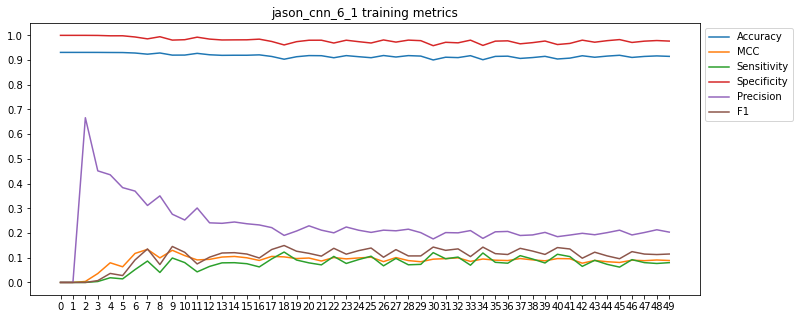

In [11]:
x_axis_ticks = np.arange(50)
y_axis_ticks = np.arange(11)/10

metrics_fig = metrics_df.plot(figsize = (12, 5), use_index = True, title = model_name + " training metrics", 
                              xticks = x_axis_ticks, yticks = y_axis_ticks)

metrics_fig = metrics_fig.legend(bbox_to_anchor=(1, 1))
metrics_fig = metrics_fig.get_figure()